# Compare a different paths of a single RGT over time

*This includes the following:*
* Position
* Position relative to the grounding line
* Flow slope along track
* Elevations along track
* Correlation lags
* Deviation comparison pre and post correlation lag corrected.

In [1]:
import shapely as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import ICESat2GroundingLineMigration.IceSatHDF5Unpacker as unpack
import src.TrackProfileUtil as util
pd.options.mode.chained_assignment = None

## Import a specific RGT & ground track

Data is imported from folders labeled by RGT number and ground track name as exported by `Export Important.ipynb`.
The data passed into `Export Important.ipynb` were the large data files as processed and exported via `S3-InitProcess.ipynb`

In [2]:
data_paths = [f"/Bung-{i}.json" for i in range(1, 18)]

In [3]:
rgt, names = 71, ["gt1r", "gt2l", "gt3r"] # RGT and name information

#additional_paths = [f"/Bungen2021-01.json", f"/Bungen2021-04.json", f"/Bungen2021-07.json", f"/Bungen2021-10.json"] # end of datapaths in each folder to grab data from.
#data_paths.extend(additional_paths)
data_paths.append(f"/Bungen2021-10.json")

study_area_path = "Bounds/bungen.gpkg" # path to polygon which clips data to be studied
proj4_crs = "+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs" # proj4 string of the coord system to be used

study_area = gpd.read_file(study_area_path)
study_area = study_area.to_crs(proj4_crs)
bounds = study_area["geometry"].total_bounds
xlim, ylim = (bounds[0], bounds[2]), (bounds[1], bounds[3])

In [4]:
data = [[], [], []] # 2d array containing unprocessed data

i = 0
for name in names:
    for path in data_paths:
        header = f"{rgt}/{name}"
        fullpath = f"Saves/{header}{path}"
        print(f"Reading file: {fullpath}          ", end= "\r")
        try:
            data[i].append(gpd.read_file(fullpath))
        except:
            print(f"File: {fullpath} not found!          ", end="\r")
    i += 1

## Basemap

The basemap is imported via `ICESat2GroundingLineMigration.IceSatHDF5Unpacker` and is then convered to a numpy array of x and y coordinates in `EPSG:3031`

In [5]:
basemap = unpack.Basemap("BackgroundData/GroundedIce.gpkg")
gline_xy = util.gline_to_df(basemap.basemap_gpd, study_area)

## Process & Extract

Here a method is defined to do some inital processing to find the along track distance at the grounding line intersection, as well as the distance to the grounding line at every point along the track.<br>
This process takes the following steps:
* **Only the data containing the desired rgt & ground track are extracted from the full dataset.**
  * This is legacy and is not needed if importing data which only has 1 ground track and/or rgt (eg. from `Export Important.ipynb`).
  * However this is necessary in nearly every other case as it is quite likely for the order and/or other aspects of the data array to get messed up if there is data from a different track around.
* **Along track distance is then computed.**
  * This is done point by point. This means it is more accurate, however it also will be incorrect if the previous step is not applied.
  * The accuracy of this distance is controlled by the distorion which the stereographic projection has.
* **Along track distance at grounding line intersection is computed.**
  * This is the along track distance to the point of grounding line intersection.
  * This process is rather complex and is performed as follows:
    * All data is converted into an x and y array and is then turned into a polyline.
    * The intersection between the polylines is computed. If there is more than 1 the first intersection is arbitrarily chosen.
    * The sign of the direction the track follows `(±x, ±y)` is computed at the points nearest to intersection
    * This is then used to compute the exact last point before the intersection occurs with the grounding line
    * The distance between the true intersection and the last point before intersection is then computed and added to the sum for along track distance at the point of intersection.
  * This process will fail if the sign of the tracks direction changes immediately after intersection. However the odds of this are incredibly low so it is not a concern.
* **Compute distance to grounding line at each point.**
  * This is done by using the nearest point function of shapely, then computing a distance.
* **Low pass filter**
  * A butterworth low pass filter is applied to all of the flowslope data. Specifically an order of `5` and a cutoff of `0.032` is used. This seems to be standard filtering for this kind of work and is cited in many places. One such place is [https://doi.org/10.5194/tc-14-3629-2020](https://doi.org/10.5194/tc-14-3629-2020)
  * This filter is digital and is applied via the scikit.signal library.

In [6]:
single_beams = [[], [], []]
i = 0
for dat in data:
    for track in dat:
        addition = util.process_and_extract(track, rgt, names[i], gline_xy, verbose=False)
        if type(addition) != type(None):
            single_beams[i].append(addition)
    i += 1

## Visualize

Shows the track relative to the grounding line.<br>
The color corresponds to the magnitude of the flowslope.

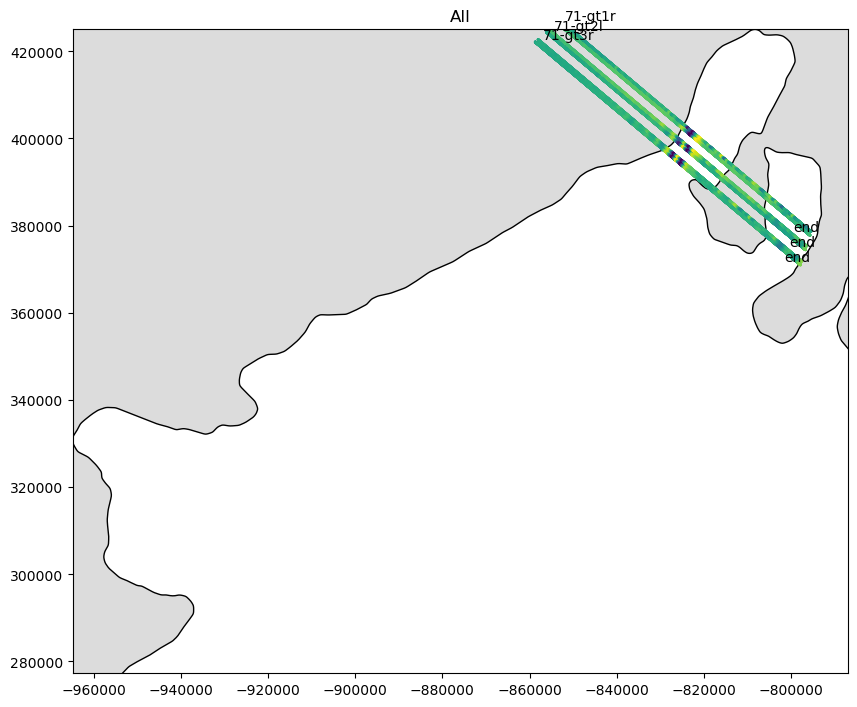

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")

for j, beam in enumerate(single_beams):
    i = 0
    for track in beam:
        x, y = np.array(track["x"]), np.array(track["y"])
        ax.scatter(x, y, s=1, c = track["slope-filt"])
        if i == 0:
            plt.text(x[0]+1e3,y[0], s=f"{rgt}-{names[j]}")
            plt.text(x[-1]-4e3,y[-1], s="end")
        i += 1
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
    
plt.show()

## Visualize #2

Plots flow slope as it relates to the along track distance.<br>
Along track distance and not the distance to the grounding line is chosen as plotting distance to the grounding line presents dicontinuities and bunching up of the data in areas where the grounding line parallels the rgt.

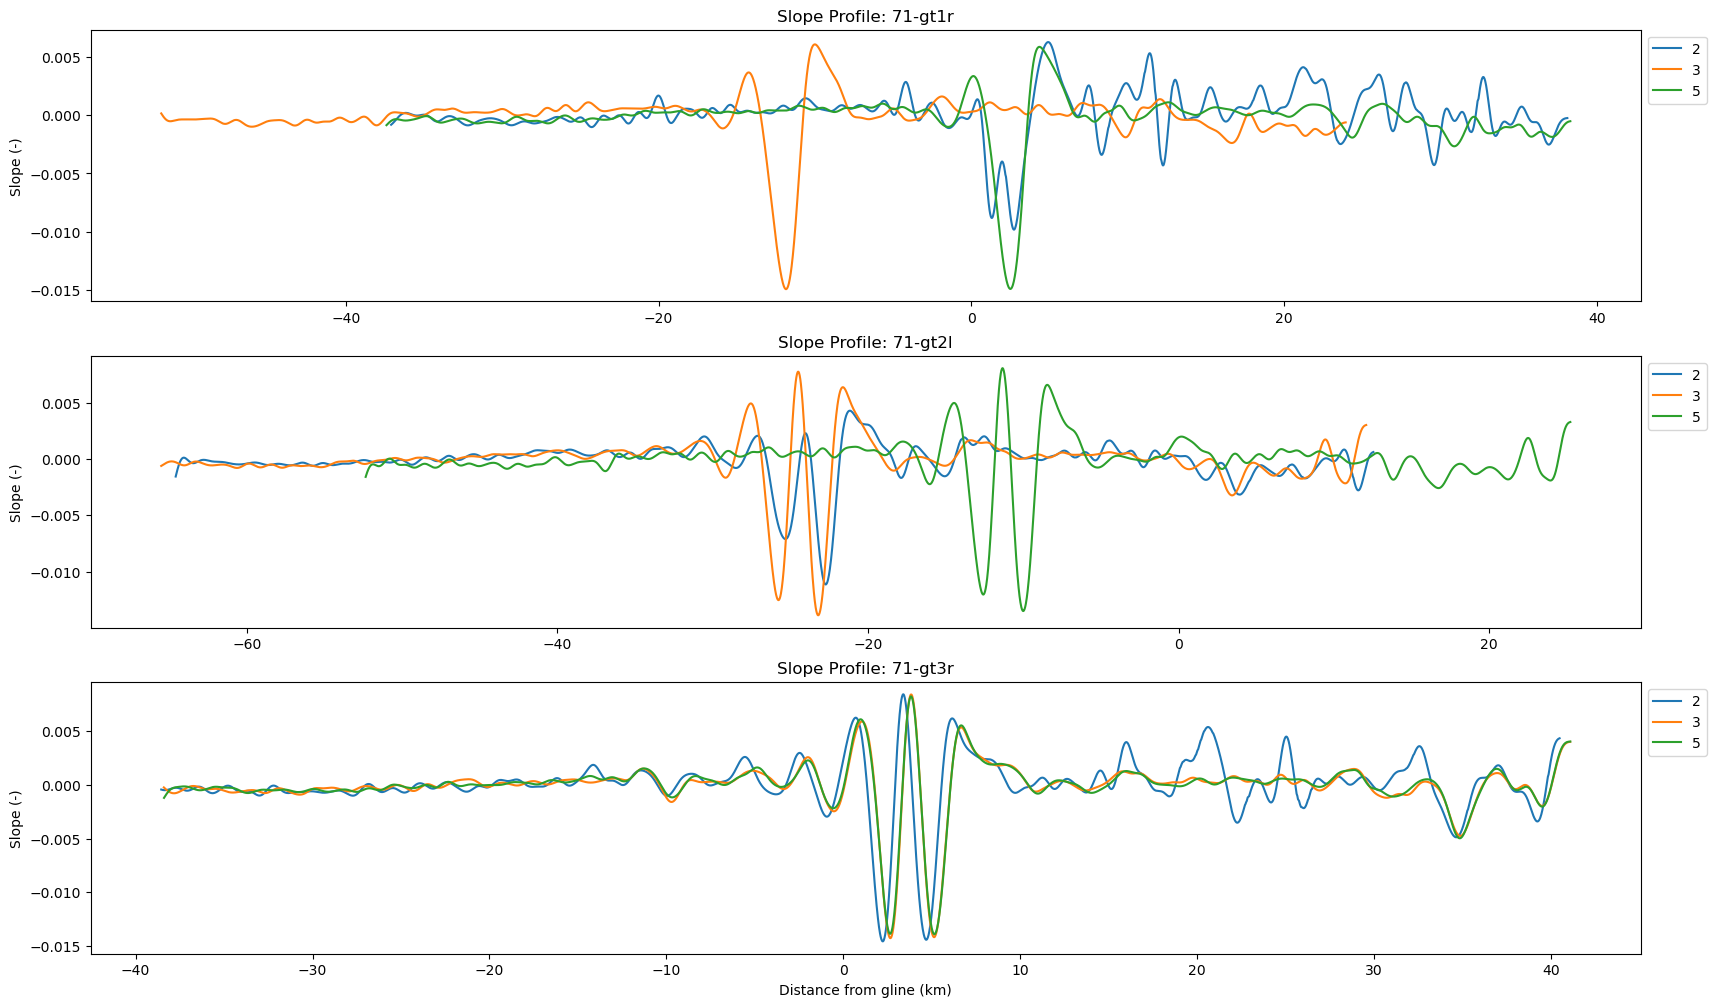

In [8]:
fig, ax = plt.subplots(3, 1, figsize = (20, 12))

i = 0
for beam in single_beams:
    j = 0
    for track in beam:
        cycle = track.iloc[0]["cycle"]
        ax[i].plot(track["along_dist"], track["slope-filt"], label=f"{cycle}")
        j += 1
    ax[i].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    ax[i].set_ylabel("Slope (-)")
    ax[i].set_title(f"Slope Profile: {rgt}-{names[i]}")
    i += 1
    
ax[2].set_xlabel("Distance from gline (km)")
    
plt.show()

## Evenly space the data

To perform all of the following desired operations the data needs to cropped to a certain region and then evenly spaced. This is done by setting a maximum along track distance from the grounding line on either side (`d_min` and `d_max`). Then evenly spaced indicies are created (of count `fidelity`) which the parameters `slope-filt` and `h_li` are then linearly interpolated onto.

The following arrays are then generated: <br>
`interped`: 2D array of interpolated data, where gaps in the data of greater than 40m are removed <br>
`interped_full`: 2D array of interpolated data, which has the gaps filled in with a linear interpolation.

In [9]:
d_min = -10
d_max = 30

cropped = [[],[],[]]
for i, beam in enumerate(single_beams):
    for j, track in enumerate(beam):
        cropped[i].append(track[(track["along_dist"] > d_min) & (track["gline_dist"] < d_max)])

In [10]:
fidelity = 5000
# interpolate then clean up bad parts of the data
interped, interped_full, idx = util.interp_clean(cropped, fidelity, d_min, d_max)


Removed 11 gaps in data


## Remove untrustworthy tracks

Tracks with less than 66% of the data within the study area being non-nan are deemed unreliable and therefore need to be removed. In other studies 50% is conventionally used, however 50% does not seem effective enough for this use case.

In [11]:
fill = 0.66

new = [[],[],[]]
new_full = [[],[],[]]
for i, interp in enumerate(interped):
    for j, track in enumerate(interp):
        nonnan = np.count_nonzero(~np.isnan(track["slope-filt"]))
        if nonnan > 5000 * fill:
            new[i].append(track)
            new_full[i].append(interped_full[i][j])
        else:
            print("cut")
interped = new
interped_full = new_full

In [12]:
src = interped[1][1]
select = src[src["along_dist"] < 0]
select.describe()

,along_dist,slope-filt,h_li
count,1250.000000,1250.000000,1250.000000
mean,-5.003001,0.000308,102.743172
std,2.888484,0.000201,0.890756
min,-10.000000,-0.000263,101.404548
25%,-7.501500,0.000168,101.993776
50%,-5.003001,0.000367,102.547656
75%,-2.504501,0.000451,103.583197
max,-0.006001,0.000599,104.238298


## Compute inital standard deviations

These standard deviations are computed across time. This means that it **is** the deviation of a single data point at a location across multiple times. Therefore it **is not** the deviation of anything relating to an entire track. This is exclusively on a point by point basis.

In [13]:
init_slope_deviations = []

for crop in interped:
    slope_filts = np.array(crop[0]["slope-filt"])
    for i in range(1, len(crop)):
        slope_filts = np.vstack((slope_filts, crop[i]["slope-filt"]))
    init_slope_deviations.append(np.nanstd(slope_filts, axis=0))

## Visualize #3

This shows the flowslope zoomed in around the grounding zone. This helps to see detail and the variations between different tracks in time.

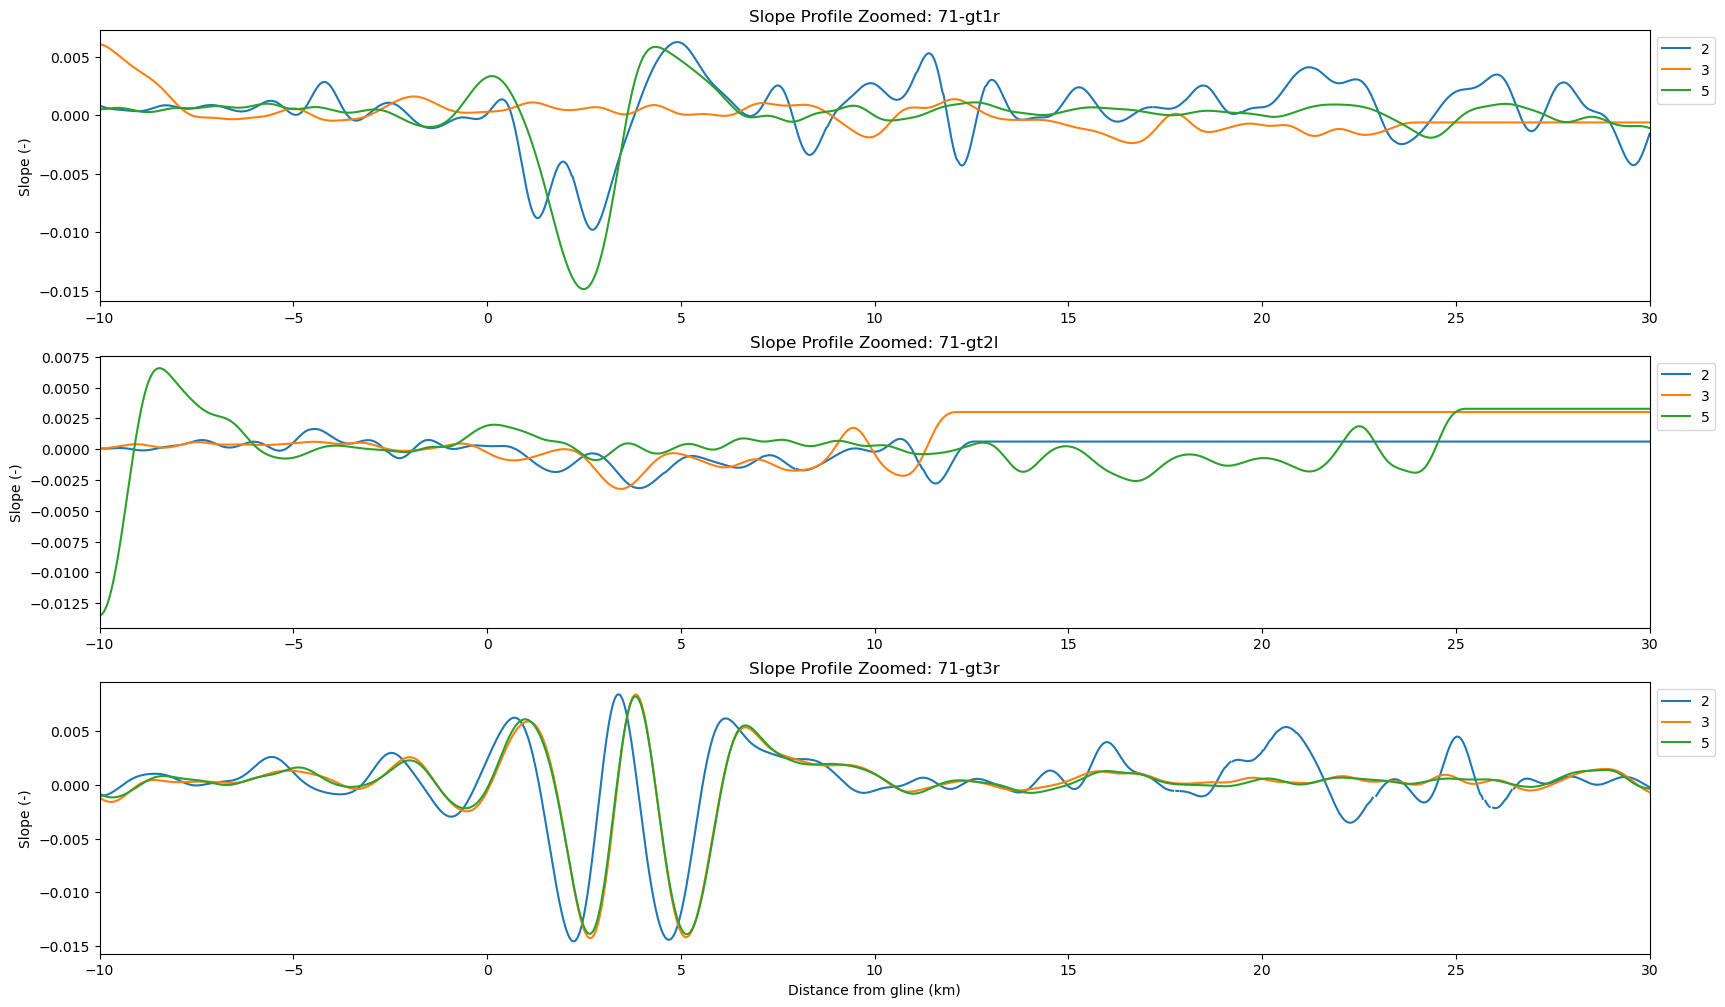

In [14]:
fig, ax = plt.subplots(3, 1, figsize = (20, 12))

i = 0
for beam in interped:
    j = 0
    for track in beam: 
        cycle = track.iloc[0]["cycle"]
        ax[i].plot(track["along_dist"], track["slope-filt"], label=f"{cycle}")
        j += 1
    ax[i].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    ax[i].set_xlim(d_min, d_max)
    ax[i].set_ylabel("Slope (-)")
    ax[i].set_title(f"Slope Profile Zoomed: {rgt}-{names[i]}")
    i += 1

ax[2].set_xlabel("Distance from gline (km)")
    
plt.show()

## Compute & correct for correlation lag

Correlation lags are computed based on the `slope-filt` parameter. The processing is done by the `scikit.signal` library. These lags are then converted from indicies into m/km based on the even spacing of the interpolated data.

In [15]:
lag_km, final_lag = util.corr_lag(interped_full, d_max, d_min, fidelity)

for i, crop in enumerate(interped):
    for j, track in enumerate(crop):
        track["along_dist"] = track["along_dist"] + lag_km[i][j]

Lags in terms of indices: [[0, 1399, 1], [0, 90, -1539], [0, -56, -55]]
Lags in meters: [[ 0.0000e+00  1.1192e+04  8.0000e+00]
 [ 0.0000e+00  7.2000e+02 -1.2312e+04]
 [ 0.0000e+00 -4.4800e+02 -4.4000e+02]]


## Visualization #4

This demonstrates the lag corrected flow slope data. From this we can see that more distinct features have a much less significant difference between the different ground tracks when correlated. Indicating the grounding zone features maintain a relatively constant profile over time. Even though that profile may translate to a different position at different points in time. The ice sheet and ice shelves can be seen to have a much greater variation indicating a lack of a constant profile.

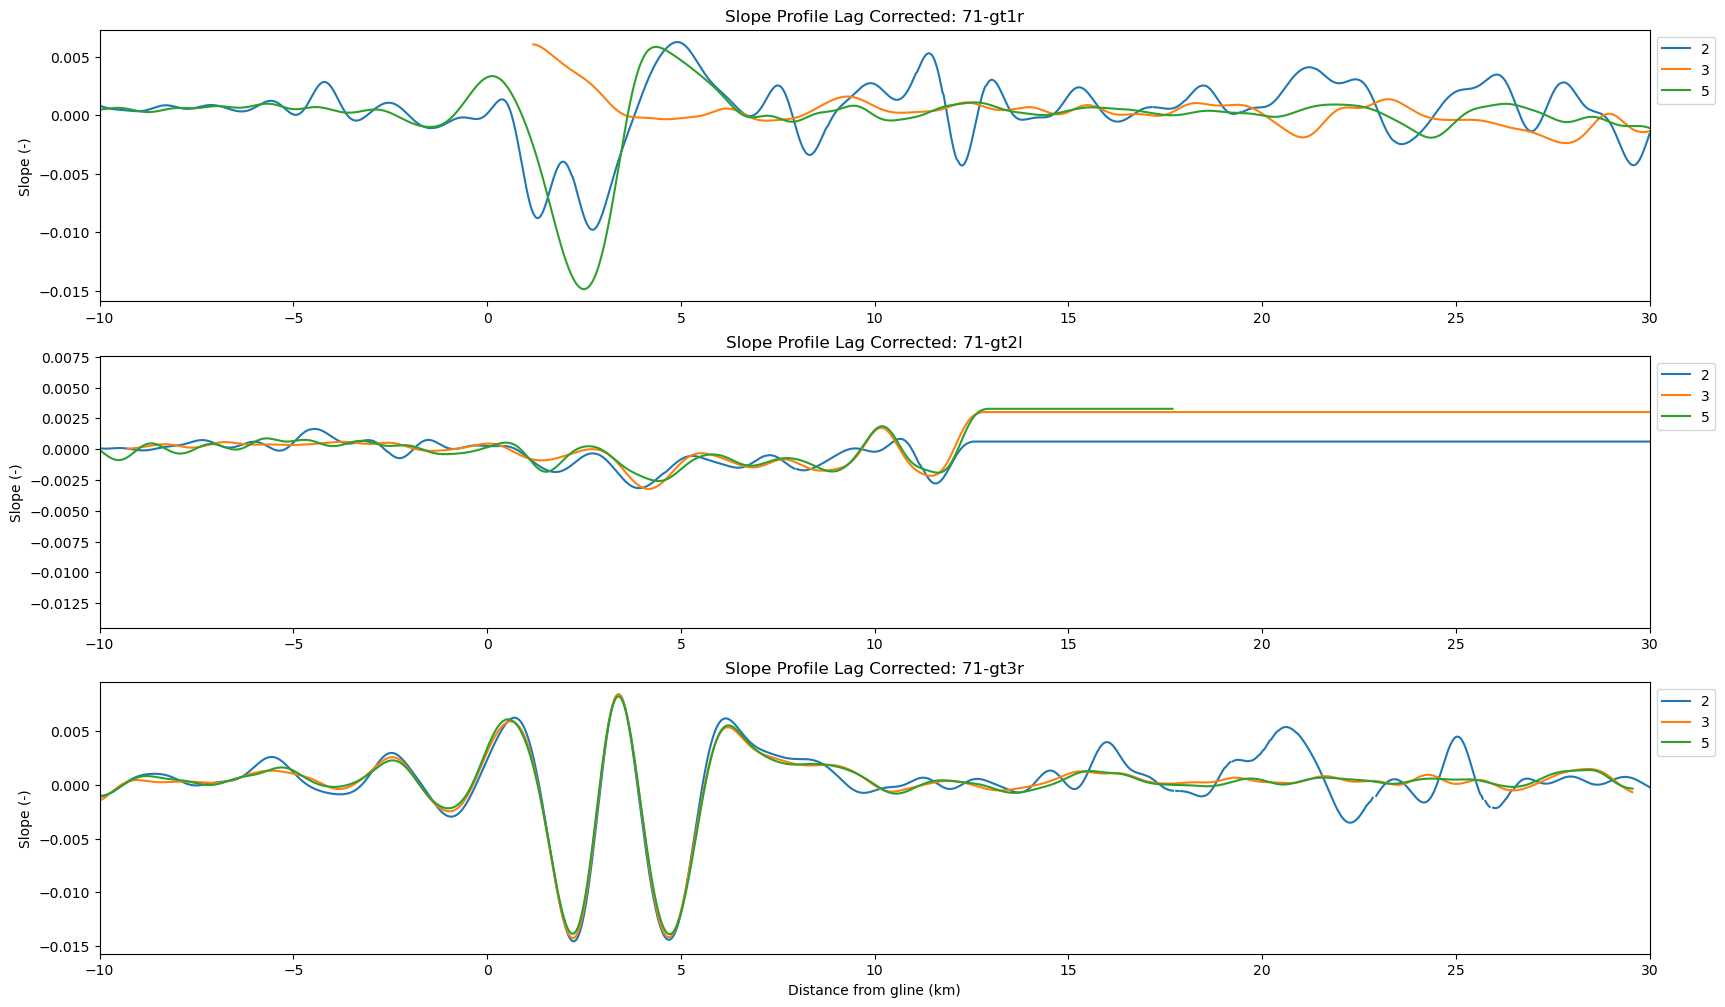

In [16]:
fig, ax = plt.subplots(3, 1, figsize = (20, 12))

i = 0
for beam in interped:
    j = 0
    for track in beam:
        cycle = track.iloc[0]["cycle"]
        ax[i].plot(track["along_dist"], track["slope-filt"], label=f"{cycle}")
        j += 1
    ax[i].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    ax[i].set_ylabel("Slope (-)")
    ax[i].set_xlim(d_min, d_max)
    ax[i].set_ylabel("Slope (-)")
    ax[i].set_title(f"Slope Profile Lag Corrected: {rgt}-{names[i]}")
    i += 1
    
ax[2].set_xlabel("Distance from gline (km)")
    
plt.show()

## Compute deviation post correlation

Change in devation is then computed by subtracting the deviation prior to correlation by the deviation post correlation.

In [17]:
slope_deviations = []

for j, crop in enumerate(interped):
    roll = final_lag[j][0]
    insert = np.roll(np.array(crop[0]["slope-filt"]), roll)
    if roll >= 0:
        insert[0:roll] = None
    else:
        insert[roll:-1] = None
    slope_filts = np.roll(insert, final_lag[j][0])
    for i in range(1, len(crop)):
        roll = final_lag[j][i]
        insert = np.roll(crop[i]["slope-filt"], final_lag[j][i])
        if roll >= 0:
            insert[0:roll] = None
        else:
            insert[roll:-1] = None
        slope_filts = np.vstack((slope_filts, insert))
    slope_deviations.append(init_slope_deviations[j] - np.nanstd(slope_filts, axis=0))

## Slope deviation peak analysis

The following plot demonstrates the relationship of the peaks of the standard deviations. X represents the index of the peak (scales to along track distance), Y represents the peaks prominence, and the color corresponds to the peaks width.

Doesn't seem like there is much to do about this??

In [18]:
import scipy.signal as signal

In [19]:
peaks, peak_prom, peak_widths = [], [], []
for dev in init_slope_deviations:
    peaks.append(signal.find_peaks(dev, height = 0.00005))
    peak_prom.append(signal.peak_prominences(dev, peaks[-1][0]))
    peak_widths.append(signal.peak_widths(dev, peaks[-1][0]))

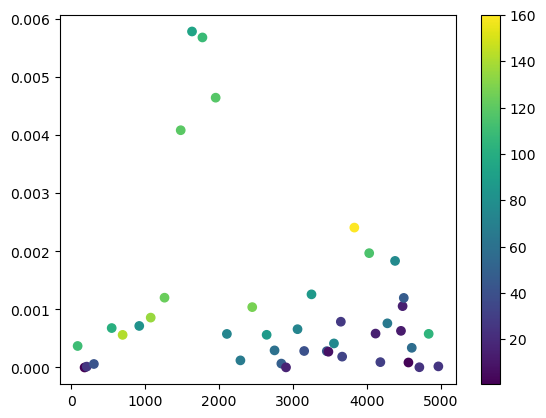

In [20]:
sc = plt.scatter(peaks[-1][0], peak_prom[-1][0], c=peak_widths[-1][0])
plt.colorbar(sc)
plt.show()

## Detecting point F (limit of tidal flexure)

https://doi.org/10.5194/tc-2022-265 uses the point where the elevation deviates from the reference elevation. Reference elevation is when the tide is 0. Then the pick the nearest peak of the 2nd derivative of elevationa as the point of tidal flexure. Here this can be understood as the first deriv of flowslope.

**Detection & selection of peaks from the 2nd deriv of height (1st of flowslope)**<br>
* Derivative is calculated
* Peaks are extracted from derivative
  * These need to have an amplitude of more than 0.003, and be distanced by more than 100 indicies (about 800m)
* Peaks with more than 5% of the data within 0.5km on either side being nan are removed due to a lack of reliability
* Only peaks where the magnitude of the flowslope at the peak is greater than 0.0005 are kept
* Only peaks where the magnitude of the standard deviation of the data within 0.5km on either side is greater than 0.001 are kept


In [21]:
deriv_peaks = [[],[],[]]

for i, interp in enumerate(interped):
    for j, track in enumerate(interp):
        # take deriv
        track = util.deriv_on_gpd(track)
        
        # find peaks
        peak_index = np.array(signal.find_peaks(track["slope_deriv_1"] * -1, height=0.003, distance = 400)[0])
        peak_dists = (((track["along_dist"].max() - track["along_dist"].min()) / 5000) * peak_index) + track["along_dist"].min()
        
        # remove peaks where 5% or more data around is nan
        final_peaks = []
        for peak in peak_dists:
            sel = track[(track["along_dist"] < peak + 0.5) & (track["along_dist"] > peak - 0.5)]
            nan = np.count_nonzero(np.isnan(sel["slope-filt"]))
            if nan < len(sel) * 0.05:
                df_sort = track.iloc[(track['along_dist']-peak).abs().argsort()[:]]
                flowslope_std = np.std(sel["slope-filt"]) 
                flowslope = df_sort.iloc[0]["slope-filt"]
                ahead_avg = np.nanmean(track[(track["along_dist"] > peak) & (track["along_dist"] < peak + 5)]["slope-filt"])
                behind_avg = np.nanmean(track[(track["along_dist"] < peak) & (track["along_dist"] > peak - 5)]["slope-filt"])
                if abs(flowslope_std) > 0.001 and abs(flowslope) > 0.0004:
                    if ahead_avg <= -0.002 and behind_avg >= -0.0013:
                        final_peaks.append(peak)
                    elif ahead_avg >= -0.001 and behind_avg <= -0.002:
                        final_peaks.append(peak)
                
        # append peaks
        final_peaks = np.array(final_peaks)
        final_peaks = final_peaks[~np.isnan(final_peaks)]
        deriv_peaks[i].append(final_peaks)

**Average of elevation profile is taken**

This is mostly taken to see if the data correlates with the tidal offsets and stuff written in other papers. <br>
It aint really used much but I'm gonna keep it here for now.

In [22]:
elev_avgs = []

for i, interp in enumerate(interped):
    elev_avg = np.array(interp[0]["h_li"])
    for j, track in enumerate(interp):
        if j != 0:
            elev_avg = np.vstack((elev_avg, track["h_li"]))
    elev_avg = np.average(elev_avg.T, axis=1)
    elev_avgs.append(elev_avg)

**Visualize selected peaks of slope deriv**

Just a debug tool, useful for finding why certain peaks are/arent detected.

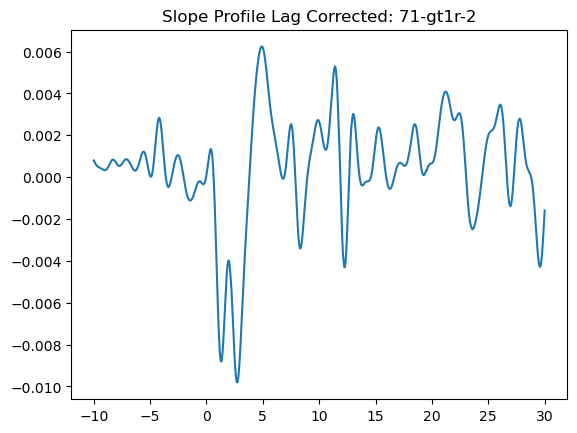

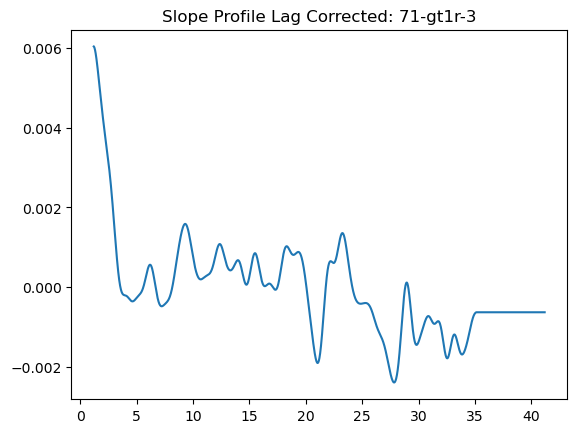

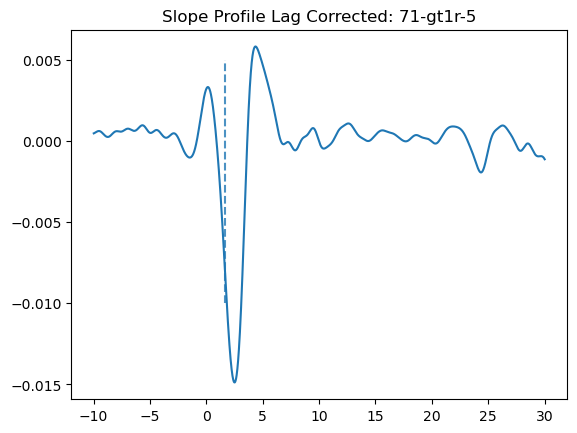

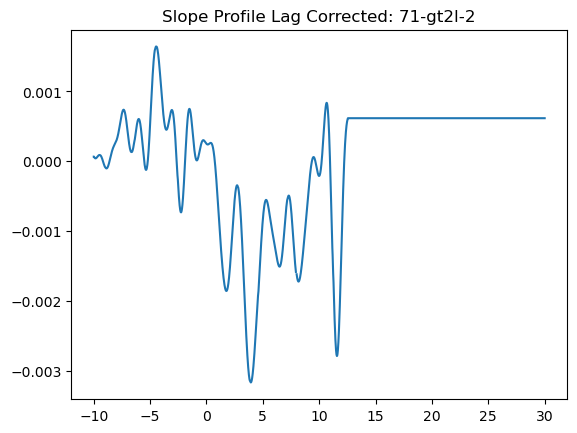

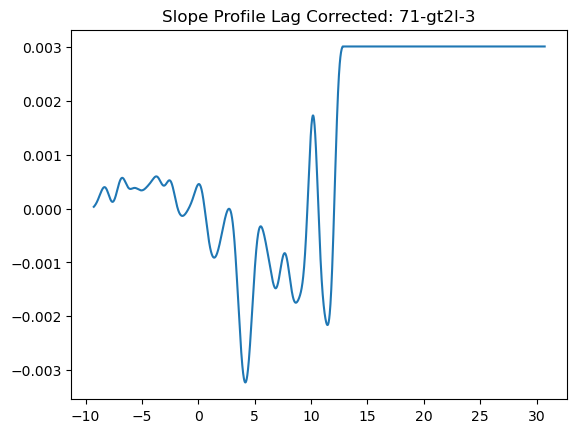

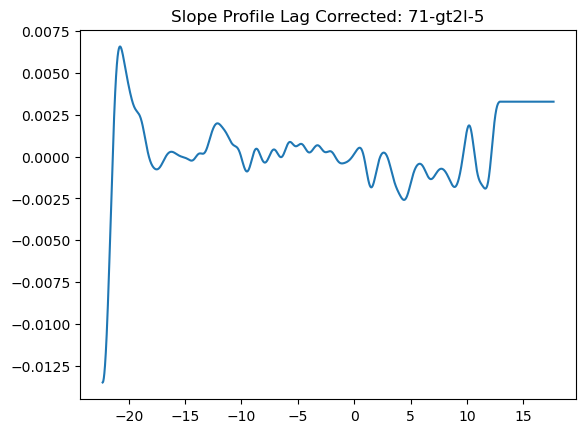

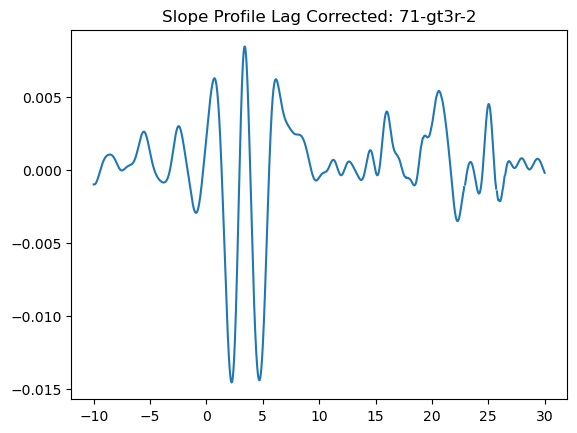

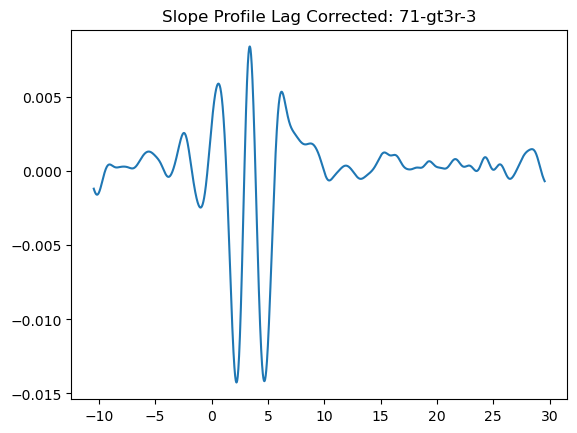

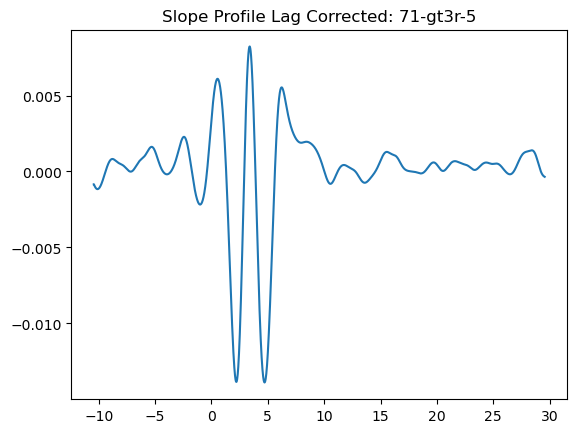

In [23]:
for i, interp in enumerate(interped):
    for j, track in enumerate(interp):
        #plt.plot(track["along_dist"], track["slope_deriv_1"])
        plt.plot(track["along_dist"], track["slope-filt"])
        plt.title(f"Slope Profile Lag Corrected: {rgt}-{names[i]}-{track.iloc[0]['cycle']}")
        #plt.vlines(deriv_peaks[i][j], ymin=-0.005, ymax=0.005, linestyles="dashed", alpha=0.8)
        plt.vlines(deriv_peaks[i][j], ymin=-0.01, ymax=0.005, linestyles="dashed", alpha=0.8)
        plt.show()

**Calculate estimate of point F for a given rgt**

This is taken as the median of the first selected peak for all cycles of a given rgt.

In [24]:
estimate = []
estimates = []
exists = []
for peaks in deriv_peaks:
    mins = np.array([min(pks) for pks in peaks if len(pks) > 0])
    exist = [True if len(pks) > 0 else False for pks in peaks]
    estimate.append(np.median(mins))
    estimates.append(mins)
    exists.append(exist)

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Visualization #5

This visualization helps to understand the relationship between 3 parameters:<br>
The elevation, the flowslope, and the change in deviation.
<br><br>
Finding correlations between these 3 could help to understand more about how the devations, or the change in devation relates to grounding line movement and other glacial features.

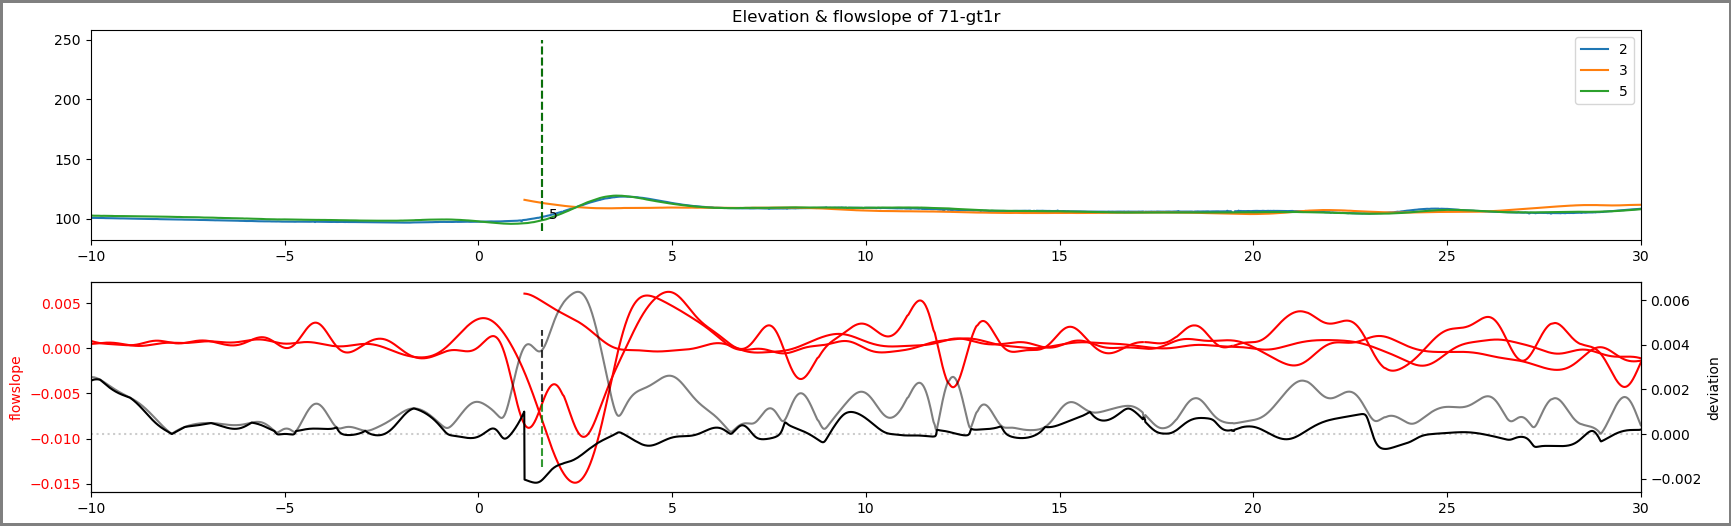

/srv/conda/envs/notebook/lib/python3.10/site-packages/matplotlib/axes/_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


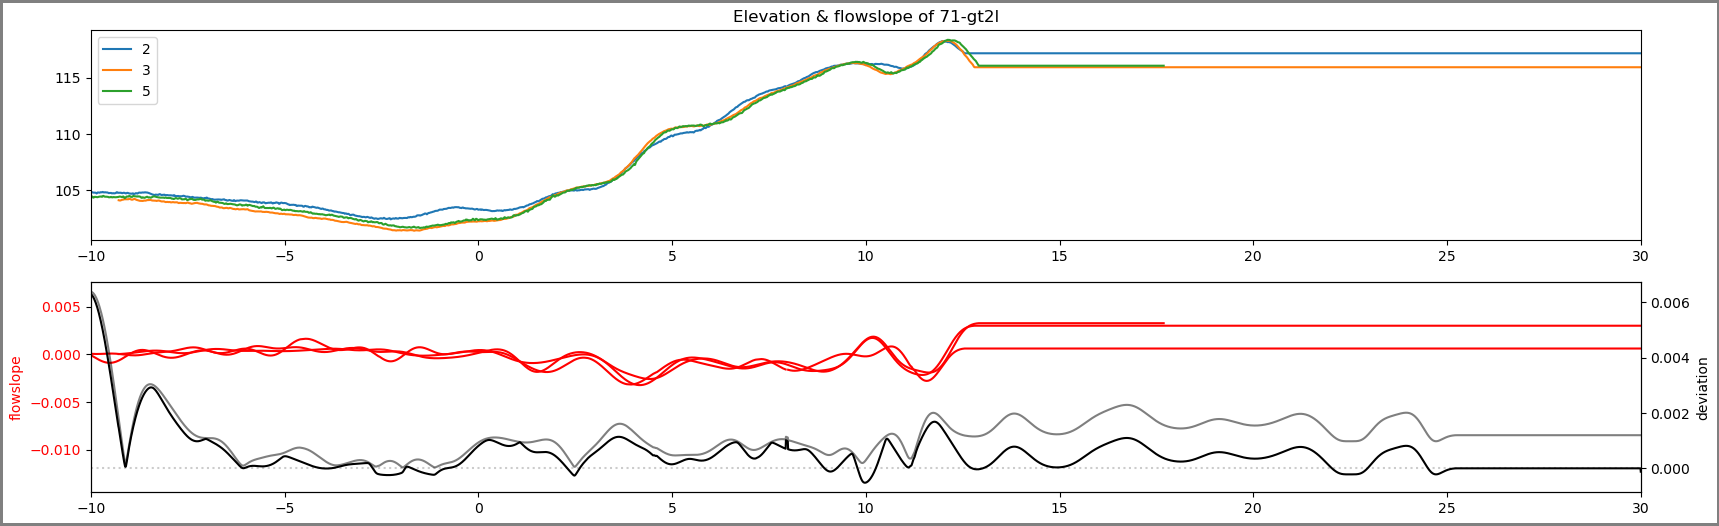

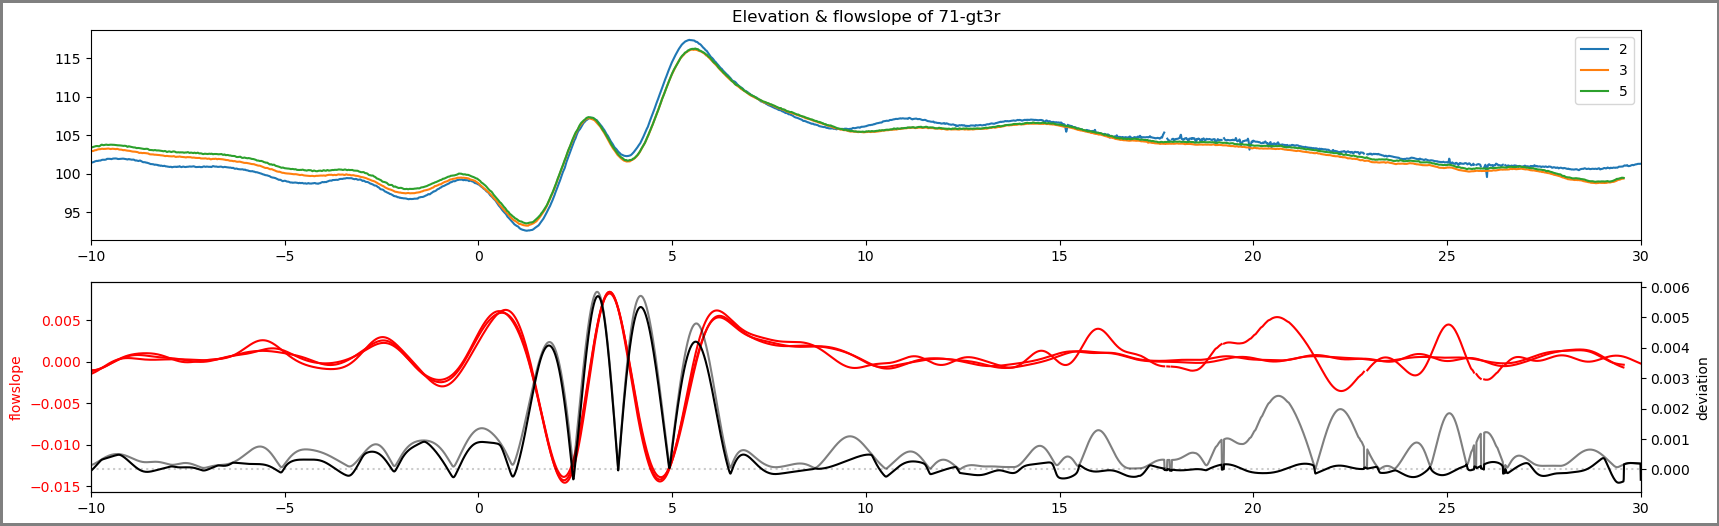

In [25]:
for i in range(len(slope_deviations)):
    
    fig, ax = plt.subplots(2, 1, figsize = (20, 6))
    
    for j, track in enumerate(interped[i]):
        ax[0].plot(track["along_dist"], track["h_li"], label=f"{track.iloc[0]['cycle']}")
        if exists[i][j] == True:
            j -= sum(~np.array(exists[i]))
            ax[0].vlines(estimates[i][j], ymin=90, ymax=250, colors="black", linestyles="dashed", alpha=0.8)
            ax[0].text(estimates[i][j] + 0.2, 100 + 15*j, f"{track.iloc[0]['cycle']}")
    ax[0].vlines(estimate[i], ymin=90, ymax=250, colors="green", linestyles="dashed", alpha=0.8)
    ax[0].set_title(f"Elevation & flowslope of {rgt}-{names[i]}")
    ax[0].legend()

    color = 'red'
    ax[1].set_ylabel('flowslope', color=color)  # we already handled the x-label with ax1
    for j, track in enumerate(interped[i]):
        ax[1].plot(track["along_dist"], track["slope-filt"], c=color)
        if exists[i][j] == True:
            j -= sum(~np.array(exists[i]))
            ax[1].vlines(estimates[i][j], ymin=-0.006, ymax=0.002, colors="black", linestyles="dashed", alpha=0.8)
        
    ax[1].tick_params(axis='y', labelcolor=color)

    ax2 = ax[1].twinx()  # instantiate a second axes that shares the same x-axis

    ax2.hlines(0, xmin=d_min, xmax=d_max, colors="black", linestyles="dotted", alpha=0.2)
    ax2.vlines(estimate[i], ymin=-0.0015, ymax=0.0015, colors="green", linestyles="dashed", alpha=0.8)

    color = "black"
    ax2.plot(idx, slope_deviations[i], color=color)
    ax2.plot(idx, init_slope_deviations[i], color=color, alpha=0.5)
    ax2.set_ylabel('deviation', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)

    ax[1].set_xlim(d_min, d_max)
    ax[0].set_xlim(d_min, d_max)
    
    fig.patch.set_linewidth(4)
    fig.patch.set_edgecolor('gray')

    plt.show()

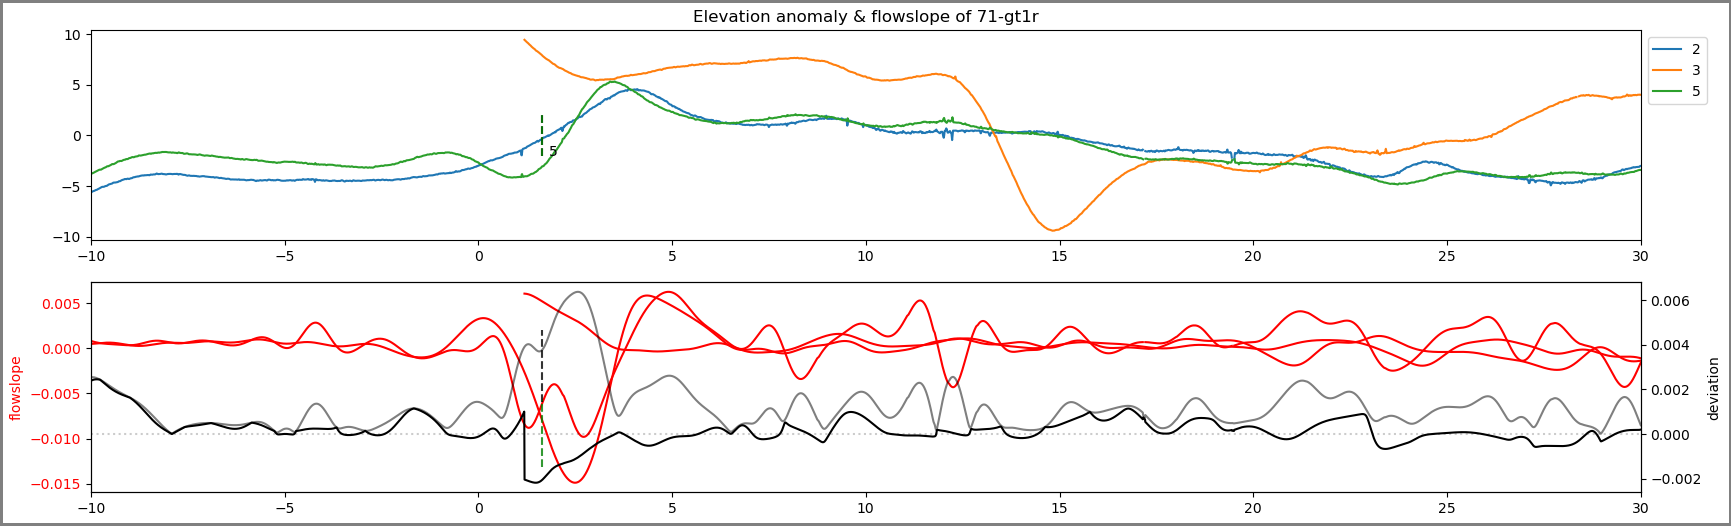

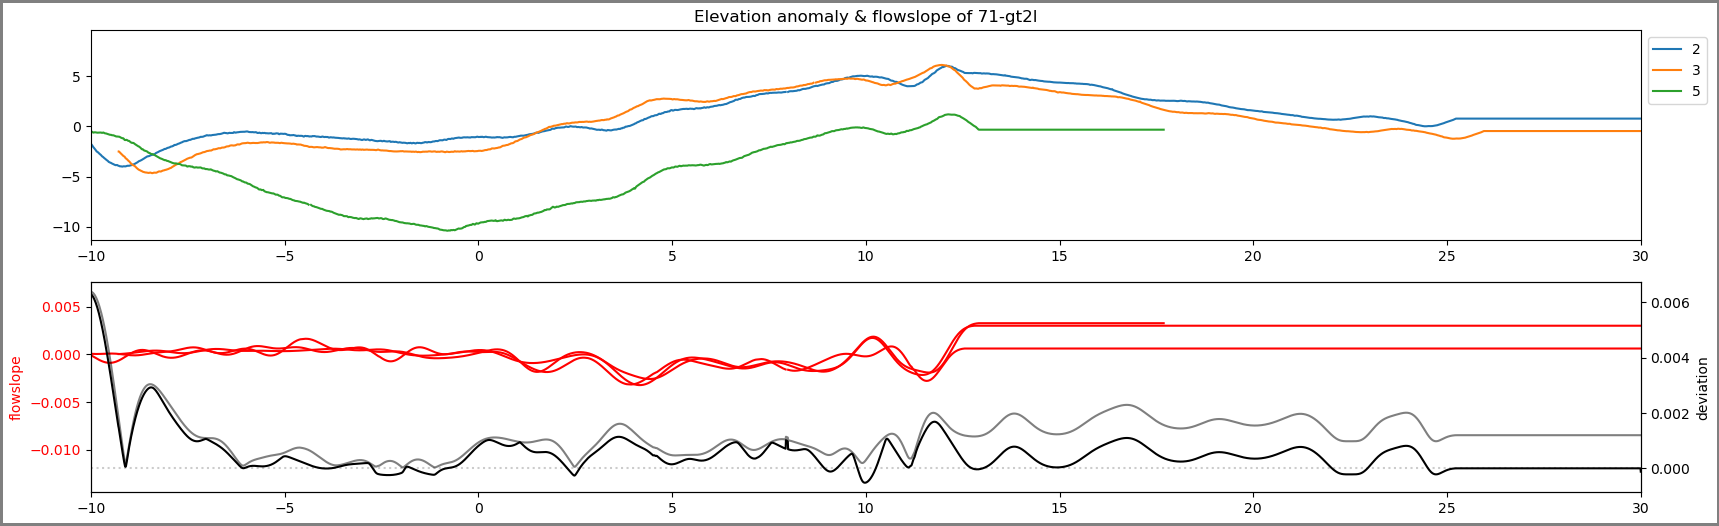

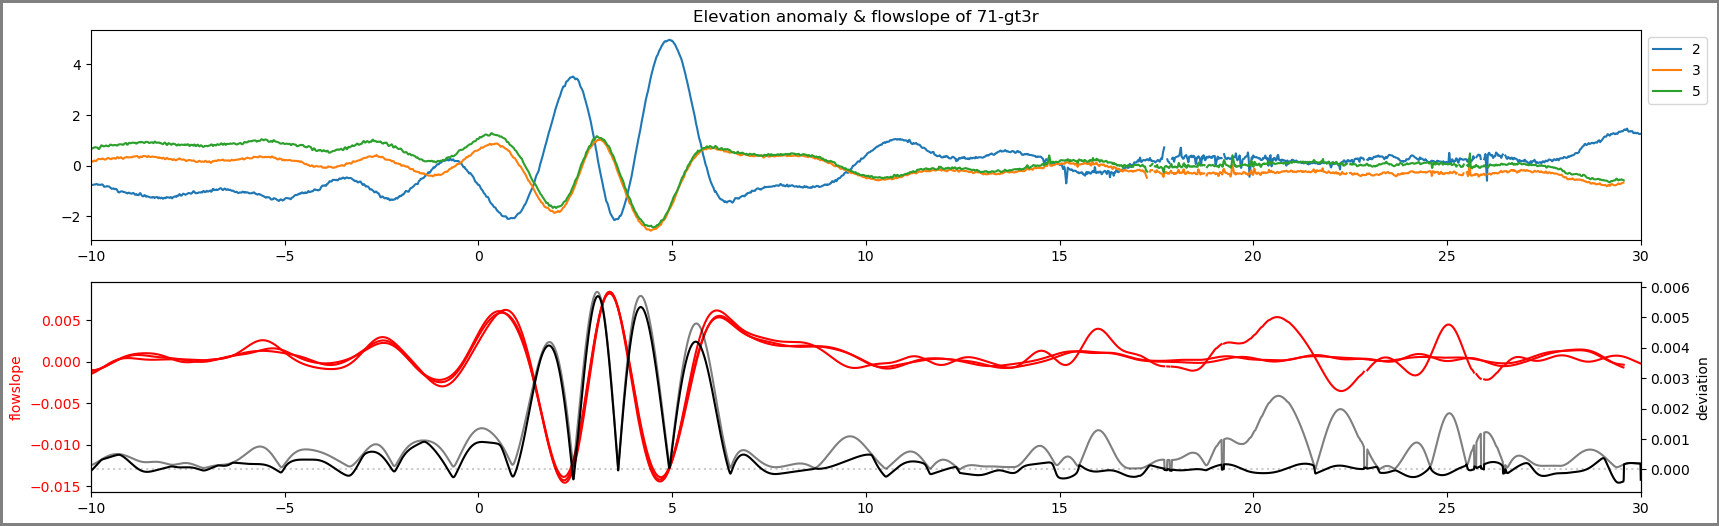

In [26]:
for i in range(len(slope_deviations)):
    
    fig, ax = plt.subplots(2, 1, figsize = (20, 6))
    
    for j, track in enumerate(interped[i]):
        ax[0].plot(track["along_dist"], track["h_li"] - elev_avgs[i], label=f"{track.iloc[0]['cycle']}")
        #ax[0].plot(track["along_dist"], track["h_li"], label=f"{track.iloc[0]['cycle']}")
        if exists[i][j] == True:
            j -= sum(~np.array(exists[i]))
            ax[0].vlines(estimates[i][j], ymin=-2, ymax=2, colors="black", linestyles="dashed", alpha=0.8)
            ax[0].text(estimates[i][j] + 0.2, -2 + 0.35*j, f"{track.iloc[0]['cycle']}")
    ax[0].vlines(estimate[i], ymin=-2, ymax=2, colors="green", linestyles="dashed", alpha=0.8)
    ax[0].set_title(f"Elevation anomaly & flowslope of {rgt}-{names[i]}")
    ax[0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

    color = 'red'
    ax[1].set_ylabel('flowslope', color=color)  # we already handled the x-label with ax1
    for j, track in enumerate(interped[i]):
        ax[1].plot(track["along_dist"], track["slope-filt"], c=color)
        if exists[i][j] == True:
            j -= sum(~np.array(exists[i]))
            ax[1].vlines(estimates[i][j], ymin=-0.006, ymax=0.002, colors="black", linestyles="dashed", alpha=0.8)
        
    ax[1].tick_params(axis='y', labelcolor=color)

    ax2 = ax[1].twinx()  # instantiate a second axes that shares the same x-axis

    ax2.hlines(0, xmin=d_min, xmax=d_max, colors="black", linestyles="dotted", alpha=0.2)
    ax2.vlines(estimate[i], ymin=-0.0015, ymax=0.0015, colors="green", linestyles="dashed", alpha=0.8)

    color = "black"
    ax2.plot(idx, slope_deviations[i], color=color)
    ax2.plot(idx, init_slope_deviations[i], color=color, alpha=0.5)
    ax2.set_ylabel('deviation', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)

    ax[1].set_xlim(d_min, d_max)
    ax[0].set_xlim(d_min, d_max)
    
    fig.patch.set_linewidth(4)
    fig.patch.set_edgecolor('gray')

    plt.show()